# Structured Data Prep Notebook
## Data Source: Melbourne Urban Forest
This workbook shows the application of the Structured Data Prep template to the [Melbourne Urban Forest dataset](https://data.melbourne.vic.gov.au/Environment/Trees-with-species-and-dimensions-Urban-Forest-/fp38-wiyy). <br>
This workbook assumes some problem qualification and Exploratory Data Analysis on the data has already taken place. In this example, Tableau was used to explore the dataset prior to prepping, so that a clear goal could be determined based on the available data. <br>
The raw data was not ready for modelling - but through following the [data prep process](http://bit.ly/2HOA18w) the data was transformed and used to train a random forest estimator.

## Contents
<a id='Section0'></a>
[1. Setup: Goal for data prep](#Section1) <br>
[2. Setup: Library and Data Source Import](#Section2) <br>
[3. Setup: Identifying Cleaning Challenges](#Section3) <br>
[4. Setup: Tidying and Deduplication](#Section4) <br>
[5. Cleaning: Missing Value Management](#Section5) <br>
[6. Cleaning: Numerical Features](#Section6) <br>
[7. Cleaning: Boolean Features](#Section7) <br>
[8. Cleaning: Date Features](#Section8) <br>
[9. Cleaning: Categorical Features](#Section9) <br>
[10. Cleaning: Other Features](#Section10) <br>
[11. Evaluation of Prepared Data](#Section11) <br>
[12. Construction of a Prep Pipeline](#Section12) <br>
[13. References](#Section13) <br>

## 1. Setup: Goal for data prep
<a id='Section1'></a>
[Go back to contents](#Section0) <br>

Using the Melbourne Urban Forest dataset, I want to predict whether I am on a street or a park in Melbourne, given features like the type or size of tree observed. This is a supervised classification problem, where we can **fit a random forest to a... random forest!**

## 2. Setup: Library and Data Source Import
<a id='Section2'></a>
[Go back to contents](#Section0) <br>
This section installs and imports some useful libraries for data prep, and provides some options on connecting with your data source. <br>
**Note - if your data is not structured, you'll need to do that first**

In [ ]:
# # Installing libraries if needed
# import sys
# # This workbook uses the Pandas Profiling library - you can install it on your local system using this code
# !{sys.executable} -m pip install pandas_profiling
# # This workbook also uses the fuzzywuzzy string matching library, which can be installed as follows
# !{sys.executable} -m pip install fuzzywuzzy
# ! {sys.executable} -m pip install python-Levenshtein
# # This workbook's EXAMPLES uses the geopy library
# !{sys.executable} -m pip install geopy

In [1]:
%%time
# This workbook uses the following libraries
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns', 200) # Good for wide datasets - otherwise it will truncate the data in views like head
import pandas_profiling # for exploration of datasets

# for missing value processing
from sklearn.preprocessing import Imputer

# for numeric processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from mlxtend.preprocessing import minmax_scaling
# for Box-Cox Transformation
from scipy import stats

# for text processing
import re 
import string
import fuzzywuzzy
from fuzzywuzzy import process

# Setting the seed for reproducibility
np.random.seed(42)

Wall time: 11.2 s


C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [3]:
%%time 
# importing data
filepath = "https://data.melbourne.vic.gov.au/api/views/fp38-wiyy/rows.csv"
data_raw = pd.read_csv(filepath,low_memory=False)

Wall time: 14.9 s


In [4]:
# validating import
data_raw

,CoM ID,Common Name,Scientific Name,Genus,Family,Diameter Breast Height,Year Planted,Date Planted,Age Description,Useful Life Expectency,Useful Life Expectency Value,Precinct,Located in,UploadDate,CoordinateLocation,Latitude,Longitude,Easting,Northing
0,1358448,Lemon Scented Gum,Corymbia citriodora,Corymbia,Myrtaceae,19.0,2009.0,02/07/2009,Semi-Mature,61+ years,80.0,NaN,Street,23/06/2018,"(-37.82019185580647, 144.94809218428176)",-37.820192,144.948092,319399.33,5812151.31
1,1492947,River Red Gum,Eucalyptus camaldulensis,Eucalyptus,Myrtaceae,NaN,2011.0,12/08/2011,NaN,NaN,NaN,NaN,Park,23/06/2018,"(-37.795788514578483, 144.9153407613388)",-37.795789,144.915341,316455.94,5814795.43
2,1033587,London Plane,Platanus acerifolia,Platanus,Platanaceae,68.0,1998.0,18/09/1998,Mature,11-20 years,20.0,NaN,Park,23/06/2018,"(-37.822137721300841, 144.97188526239677)",-37.822138,144.971885,321498.41,5811981.13
3,1055443,Ovens Wattle,Acacia pravissima,Acacia,Fabaceae,20.0,1999.0,25/01/1999,Semi-Mature,21-30 years,30.0,NaN,Park,23/06/2018,"(-37.780294102194212, 144.95186111862597)",-37.780294,144.951861,319634.05,5816585.89
4,1663643,Coastal Banksia,Banksia integrifolia,Banksia,Proteaceae,NaN,2017.0,29/05/2017,NaN,NaN,NaN,NaN,Park,23/06/2018,"(-37.800102558156503, 144.91200662800514)",-37.800103,144.912007,316173.05,5814310.16
5,1045822,River Red Gum,Eucalyptus camaldulensis,Eucalyptus,Myrtaceae,NaN,1998.0,12/03/1998,NaN,NaN,NaN,NaN,Park,23/06/2018,"(-37.789409969261925, 144.95549169511168)",-37.789410,144.955492,319975.93,5815581.34
6,1034140,Algerian Oak,Quercus canariensis,Quercus,Fagaceae,NaN,1900.0,01/01/2000,NaN,NaN,NaN,NaN,Street,23/06/2018,"(-37.829877875773839, 144.98734809676066)",-37.829878,144.987348,322878.00,5811151.68
7,1527192,Monterey Pine,Pinus radiata,Pinus,Pinaceae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Park,23/06/2018,"(-37.779506044660593, 144.94799998925538)",-37.779506,144.948000,319292.07,5816665.88
8,1604886,River Red Gum,Eucalyptus camaldulensis,Eucalyptus,Myrtaceae,NaN,2015.0,25/08/2015,NaN,NaN,NaN,NaN,Park,23/06/2018,"(-37.795425332272657, 144.95209457765654)",-37.795425,144.952095,319691.40,5814907.29
9,1286837,London Plane,Platanus acerifolia,Platanus,Platanaceae,20.0,NaN,NaN,Juvenile,61+ years,80.0,NaN,Park,23/06/2018,"(-37.820973579880409, 144.97425126305006)",-37.820974,144.974251,321703.87,5812114.83


In [5]:
# saving to local dir (to save downloading again)
data_raw.to_csv('data/trees_raw.csv')

## 3. Setup: Identifying Cleaning Challenges
<a id='Section3'></a>
[Go back to contents](#Section0) <br>
This section includes:
- Understanding default data types and columns
- Understanding nulls
- Using the Pandas Profiler to deep dive into variables
- Evaluating some of the challenges

In [6]:
# Evaluate column names, types, nulls, using info.
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69790 entries, 0 to 69789
Data columns (total 19 columns):
CoM ID                          69790 non-null int64
Common Name                     69545 non-null object
Scientific Name                 69724 non-null object
Genus                           69724 non-null object
Family                          69724 non-null object
Diameter Breast Height          26480 non-null float64
Year Planted                    61475 non-null float64
Date Planted                    61475 non-null object
Age Description                 26462 non-null object
Useful Life Expectency          26462 non-null object
Useful Life Expectency Value    26462 non-null float64
Precinct                        0 non-null float64
Located in                      69628 non-null object
UploadDate                      69790 non-null object
CoordinateLocation              69790 non-null object
Latitude                        69790 non-null float64
Longitude                  

In [7]:
# Evaluate numerical items using describe
data_raw.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
CoM ID,69790.0,1.292262e+06,255485.113818,1.013381e+06,1.045342e+06,1.287316e+06,1.525656e+06,1.735406e+06
Diameter Breast Height,26480.0,3.738285e+01,31.394095,0.000000e+00,1.400000e+01,2.900000e+01,5.500000e+01,3.470000e+02
Year Planted,61475.0,1.996333e+03,31.562008,1.899000e+03,1.998000e+03,2.006000e+03,2.013000e+03,2.018000e+03
Useful Life Expectency Value,26462.0,3.818778e+01,25.143532,1.000000e+00,2.000000e+01,3.000000e+01,6.000000e+01,8.000000e+01
Precinct,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latitude,69790.0,-3.780132e+01,0.016456,-3.785054e+01,-3.781397e+01,-3.779621e+01,-3.778876e+01,-3.777546e+01
Longitude,69790.0,1.449520e+02,0.018462,1.449004e+02,1.449436e+02,1.449516e+02,1.449642e+02,1.449911e+02
Easting,69790.0,3.196936e+05,1641.364679,3.152295e+05,3.189305e+05,3.196347e+05,3.207891e+05,3.231593e+05
Northing,69790.0,5.814253e+06,1812.561583,5.808852e+06,5.812884e+06,5.814796e+06,5.815639e+06,5.817097e+06


In [8]:
# Evaluate object and categorical items using describe - are they high in cardinality?!?
data_raw.describe(include=[np.object,pd.Categorical]).T

,count,unique,top,freq
Common Name,69545,370,River Red Gum,7925
Scientific Name,69724,460,Eucalyptus camaldulensis,7917
Genus,69724,139,Eucalyptus,16758
Family,69724,48,Myrtaceae,27474
Date Planted,61475,1461,01/01/2000,3434
Age Description,26462,5,Semi-Mature,11117
Useful Life Expectency,26462,10,31-60 years,7601
Located in,69628,2,Park,40431
UploadDate,69790,1,23/06/2018,69790
CoordinateLocation,69790,69586,"(-37.785400121796584, 144.95432601989748)",2


In [9]:
%%time
# Create a "pandas profile report" to help rule out features and enable efficient deep dives into a feature.
report = pandas_profiling.ProfileReport(data_raw)
# report.to_file(outputfile="raw_data_profile.html")

Wall time: 34 s


In [10]:
report

Number of variables,19
Number of observations,69790
Total Missing (%),19.6%
Total size in memory,10.1 MiB
Average record size in memory,152.0 B
Numeric,6
Categorical,9
Boolean,0
Date,0
Text (Unique),0
Rejected,4


In [13]:
report.to_file(outputfile="data/raw_data_profile.html")

In [11]:
# You can also see what variables the report recommends excluding based upon a correlation with other variables >0.9
report.get_rejected_variables()

['Easting', 'Northing']

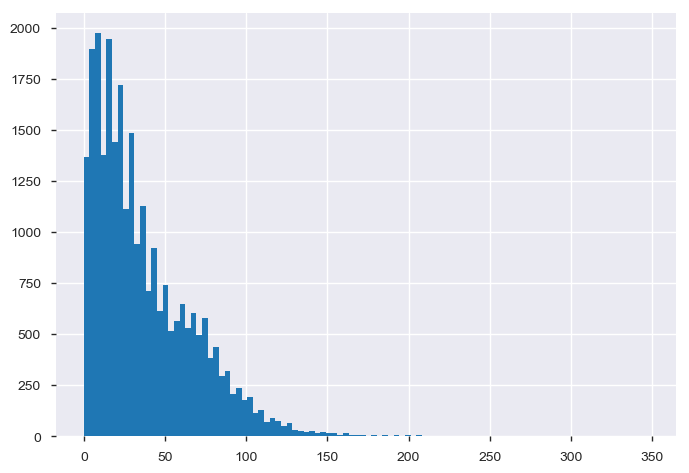

In [12]:
# finally matplot.lib and Boolean Indexing can help deep dive on fields with strange distributions
data_raw['Diameter Breast Height'].dropna().hist(bins=100)

**Notes:** <br>
- Identifier is CoM ID
- Target variable candidate is "Located in"
- There are a number of redundant columns that should be deleted
- Missing values are a problem with Date Planted, Diameter Breast Height, Age Description
- Lats and Longs are provided - but given the "Located in" tag, are probably useless
- High cardinality in categorical features like "Common Name" - will need to be reduced

## 4. Setup: Tidying and Deduplication
<a id='Section4'></a>
[Go back to contents](#Section0) <br>
This section involves:
- Standardizing column names.
- Evaluating whether each row is a sample, and what transforms are needed to bring this about.
- Testing for duplicates, and Identifying an index for each sample (where possible)
- Sorting columns into the following **data types**: numerical, boolean, date, categorical, and other.

In [14]:
# As per Chris Albion, it is best practice to treat a data frame as immuatable, and to copy before manipulation (to protect against mistakes)

# Copying the raw data file:
data_prep_1 = data_raw.copy()

# Standardizing column names to snake case:
data_prep_1.columns = [c.replace(' ', '_') for c in data_prep_1.columns]
data_prep_1.columns =  [c.lower() for c in data_prep_1.columns]
data_prep_1.columns = [re.sub(r'\W+','_',c) for c in data_prep_1.columns]

# Reporting the resulting columns as a list for later indexing
data_prep_1.columns.tolist()

['com_id',
 'common_name',
 'scientific_name',
 'genus',
 'family',
 'diameter_breast_height',
 'year_planted',
 'date_planted',
 'age_description',
 'useful_life_expectency',
 'useful_life_expectency_value',
 'precinct',
 'located_in',
 'uploaddate',
 'coordinatelocation',
 'latitude',
 'longitude',
 'easting',
 'northing']

In [15]:
# Evaluating the shape of the dataframe, and whether each row is a sample and each column is a variable
# A random sample is thought to be a good way to do this.
data_prep_1.sample(20)

,com_id,common_name,scientific_name,genus,family,diameter_breast_height,year_planted,date_planted,age_description,useful_life_expectency,useful_life_expectency_value,precinct,located_in,uploaddate,coordinatelocation,latitude,longitude,easting,northing
44628,1046342,Yellow Box,Eucalyptus melliodora,Eucalyptus,Myrtaceae,NaN,1998.0,12/07/1998,NaN,NaN,NaN,NaN,Park,23/06/2018,"(-37.788330112628657, 144.95255699774663)",-37.788330,144.952557,319714.87,5815695.51
58330,1521411,River Red Gum,Eucalyptus camaldulensis,Eucalyptus,Myrtaceae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Park,23/06/2018,"(-37.783607141705858, 144.94687360366814)",-37.783607,144.946874,319202.86,5816208.62
31664,1553124,Hills Fig,Ficus microcarpa var. hillii,Ficus,Moraceae,NaN,2013.0,09/10/2013,NaN,NaN,NaN,NaN,Street,23/06/2018,"(-37.798207168927412, 144.97464182515264)",-37.798207,144.974642,321683.48,5814641.87
6705,1525249,Black Wattle,Acacia melanoxylon,Acacia,Fabaceae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Park,23/06/2018,"(-37.782046433880822, 144.94897082437305)",-37.782046,144.948971,319383.76,5816385.86
47157,1054555,River Red Gum,Eucalyptus camaldulensis,Eucalyptus,Myrtaceae,NaN,1999.0,19/01/1999,NaN,NaN,NaN,NaN,Park,23/06/2018,"(-37.787182911208888, 144.94324711620533)",-37.787183,144.943247,318892.21,5815804.81
36998,1021405,London Plane,Platanus acerifolia,Platanus,Platanaceae,27.0,1997.0,11/04/1997,Semi-Mature,6-10 years (>50% canopy),10.0,NaN,Street,23/06/2018,"(-37.799973347041735, 144.97156583832992)",-37.799973,144.971566,321416.89,5814440.01
30865,1735171,Moonah,Melaleuca lanceolata,Melaleuca,Myrtaceae,NaN,2018.0,21/05/2018,NaN,NaN,NaN,NaN,Street,23/06/2018,"(-37.802472293646062, 144.9220798246393)",-37.802472,144.922080,317065.84,5814066.97
52203,1493696,White Cedar,Melia azedarach,Melia,Meliaceae,NaN,2011.0,30/09/2011,NaN,NaN,NaN,NaN,Street,23/06/2018,"(-37.805732954317811, 144.95327982097533)",-37.805733,144.953280,319820.82,5813765.78
58211,1288436,Yellow Box,Eucalyptus leucoxylon Rosea,Eucalyptus,Myrtaceae,15.0,2008.0,15/09/2008,Semi-Mature,31-60 years,60.0,NaN,Street,23/06/2018,"(-37.777355795966201, 144.9411914352159)",-37.777356,144.941191,318687.16,5816891.30
10280,1439505,tba,Acer unknown X fremanii Jeffersred autumn blaze,Acer,Sapindaceae,3.0,2009.0,01/12/2009,New,31-60 years,60.0,NaN,Street,23/06/2018,"(-37.810785154889523, 144.98866691739423)",-37.810785,144.988667,322948.45,5813272.82


**Notes on tidiness evaluation:** <br>
Goal is to predict whether the location is a park or a street based on the tree characteristics. <br>
From that standpoint, each row is a sample (a single tree), most columns are variables, and most cells are values <br>
There are three exceptions to be managed <br>
- Date planted is only split into year and exact date - week, month, should be calculated to ensure all variables are teased out, though may be more practical to drop this variable.
- Coordinate location appears to be concatenated lats and longs - redundant so will be dropped. <br>

*Conclusion: No transformations needed.*

In [16]:
# testing for duplicates - first across all features
data_prep_1[data_prep_1.duplicated()]

,com_id,common_name,scientific_name,genus,family,diameter_breast_height,year_planted,date_planted,age_description,useful_life_expectency,useful_life_expectency_value,precinct,located_in,uploaddate,coordinatelocation,latitude,longitude,easting,northing


In [17]:
# testing for duplicates - then across index candidate
index = "com_id"
data_prep_1[data_prep_1.duplicated(subset=index)]

,com_id,common_name,scientific_name,genus,family,diameter_breast_height,year_planted,date_planted,age_description,useful_life_expectency,useful_life_expectency_value,precinct,located_in,uploaddate,coordinatelocation,latitude,longitude,easting,northing


In [18]:
# Removing a duplicate from the index
data_prep_2 = data_prep_1.drop_duplicates(subset=index, keep='first')

In [19]:
# Reindexing on the new variable
data_prep_3 = data_prep_2.set_index(index) # note this will delete the index from the columns
data_prep_3

,common_name,scientific_name,genus,family,diameter_breast_height,year_planted,date_planted,age_description,useful_life_expectency,useful_life_expectency_value,precinct,located_in,uploaddate,coordinatelocation,latitude,longitude,easting,northing
com_id,,,,,,,,,,,,,,,,,,
1358448,Lemon Scented Gum,Corymbia citriodora,Corymbia,Myrtaceae,19.0,2009.0,02/07/2009,Semi-Mature,61+ years,80.0,NaN,Street,23/06/2018,"(-37.82019185580647, 144.94809218428176)",-37.820192,144.948092,319399.33,5812151.31
1492947,River Red Gum,Eucalyptus camaldulensis,Eucalyptus,Myrtaceae,NaN,2011.0,12/08/2011,NaN,NaN,NaN,NaN,Park,23/06/2018,"(-37.795788514578483, 144.9153407613388)",-37.795789,144.915341,316455.94,5814795.43
1033587,London Plane,Platanus acerifolia,Platanus,Platanaceae,68.0,1998.0,18/09/1998,Mature,11-20 years,20.0,NaN,Park,23/06/2018,"(-37.822137721300841, 144.97188526239677)",-37.822138,144.971885,321498.41,5811981.13
1055443,Ovens Wattle,Acacia pravissima,Acacia,Fabaceae,20.0,1999.0,25/01/1999,Semi-Mature,21-30 years,30.0,NaN,Park,23/06/2018,"(-37.780294102194212, 144.95186111862597)",-37.780294,144.951861,319634.05,5816585.89
1663643,Coastal Banksia,Banksia integrifolia,Banksia,Proteaceae,NaN,2017.0,29/05/2017,NaN,NaN,NaN,NaN,Park,23/06/2018,"(-37.800102558156503, 144.91200662800514)",-37.800103,144.912007,316173.05,5814310.16
1045822,River Red Gum,Eucalyptus camaldulensis,Eucalyptus,Myrtaceae,NaN,1998.0,12/03/1998,NaN,NaN,NaN,NaN,Park,23/06/2018,"(-37.789409969261925, 144.95549169511168)",-37.789410,144.955492,319975.93,5815581.34
1034140,Algerian Oak,Quercus canariensis,Quercus,Fagaceae,NaN,1900.0,01/01/2000,NaN,NaN,NaN,NaN,Street,23/06/2018,"(-37.829877875773839, 144.98734809676066)",-37.829878,144.987348,322878.00,5811151.68
1527192,Monterey Pine,Pinus radiata,Pinus,Pinaceae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Park,23/06/2018,"(-37.779506044660593, 144.94799998925538)",-37.779506,144.948000,319292.07,5816665.88
1604886,River Red Gum,Eucalyptus camaldulensis,Eucalyptus,Myrtaceae,NaN,2015.0,25/08/2015,NaN,NaN,NaN,NaN,Park,23/06/2018,"(-37.795425332272657, 144.95209457765654)",-37.795425,144.952095,319691.40,5814907.29


In [20]:
# Creating a list of irrelevant columns based on the profile report and other observations
manual_exclude_list = ['scientific_name','genus','family','uploaddate','useful_life_expectency','precinct','easting','northing','coordinatelocation']
cols_exclude_total = manual_exclude_list # This may seem redundant, but there is an intent to add in the profiler excluded variables
cols_exclude_total

['scientific_name',
 'genus',
 'family',
 'uploaddate',
 'useful_life_expectency',
 'precinct',
 'easting',
 'northing',
 'coordinatelocation']

**Justification for manually excluded columns:** <br>
'scientific_name','genus' - redundant given we are using common_name as a feature <br>
'uploaddate', 'precinct' - single value <br>
'useful_life_expectency' - already encoded into a numerical feature (redundant) <br>
'easting','northing' - redundant given we have lat and lon (flagged by the profiler report) <br>
'coordinatelocation' -  given we have lat and lon

In [21]:
# Sorting columns - defining the logic for the sort:
def feature_sort(cols_num,cols_bool,cols_date,cols_cat,cols_other,cols_exclude_total):
    for col in data_prep_3.columns:
        if col not in cols_exclude_total + cols_num + cols_bool + cols_date + cols_cat + cols_other:
            if col in data_prep_3.columns[(data_prep_3.dtypes == np.float64) | (data_prep_3.dtypes == np.float32)]:
                cols_num.append(col)
            elif (data_prep_3[col].nunique() == 2) or ("true" in data_prep_3[col].unique()) or ("false" in data_prep_3[col].unique()) \
            or ("yes" in data_prep_3[col].unique()) or ("no" in data_prep_3[col].unique()):
                cols_bool.append(col)
            elif 'date' in str(col):
                cols_date.append(col)
            elif data_prep_3[col].nunique() < data_prep_3.shape[0]/100: # Arbitrary limit
                cols_cat.append(col)
            else:
                cols_other.append(col)
    return cols_num,cols_bool,cols_date,cols_cat,cols_other

In [40]:
# exceptions can be handled by placing their values in the column names before executing the for loop
cols_num = []
cols_bool = []
cols_date = []
cols_cat = []
cols_other = ['latitude', 'longitude']

In [42]:
# Running the sort
cols_num,cols_bool,cols_date,cols_cat,cols_other = feature_sort(cols_num,cols_bool,cols_date,cols_cat,cols_other,cols_exclude_total)

In [43]:
# Evalaute the results of the sort
[print(key+" features:",value,sep='\n') for key,value in {"cols_num":cols_num,"cols_bool":cols_bool,"cols_date":cols_date,\
                                          "cols_cat":cols_cat,"cols_other":cols_other}.items()]

cols_num features:
['diameter_breast_height', 'year_planted', 'useful_life_expectency_value']
cols_bool features:
['located_in']
cols_date features:
['date_planted']
cols_cat features:
['common_name', 'age_description']
cols_other features:
['latitude', 'longitude']


[None, None, None, None, None]

In [25]:
# Removing Irrelevant features
data_prep_4 = data_prep_3.drop(labels=cols_exclude_total,axis = 1)
data_prep_4.columns

Index(['common_name', 'diameter_breast_height', 'year_planted', 'date_planted',
       'age_description', 'useful_life_expectency_value', 'located_in',
       'latitude', 'longitude'],
      dtype='object')

#### References for section 4: 
##### Pandas Data Wrangling Functions
[Cheat Sheet](https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf) <br>
*Credit - Irv Lustig, Princeton Consultants*
##### Tidy Data
**Image:** Definition of variables, observations, and values in Tidy Data <br>
*Image Credit - R for Data Science (Hadley Wickham & Garrett Grolemund)* <br>
<img align="left" width="500" height="500" src="images/tidy data.png">

## 5. Cleaning: Missing Value Management
<a id='Section5'></a>
[Go back to contents](#Section0) <br>
This section covers missing value management, and helps makes decisions on whether to drop values, impute values, or handle them otherwise.
- Ensure we have detected all nans
- Evaluate how many nans we have
- Evaluate how important a feature is
- Evaluate why the values are NaN - were the not recorded, or do they not exist?
- Flag values for imputation during analysis
- Drop values for the unimportant columns

In [26]:
# Check category features for "nulls" hiding behind other values (a common gotcha!) 
[print(str(c)+' value counts',data_prep_4[c].value_counts(),sep="\n") for c in cols_cat]

common_name value counts
River Red Gum                 7925
London Plane                  5313
Spotted Gum                   3130
Yellow Box                    2968
Drooping She-Oak              2748
Elm                           2493
Black Wattle                  2347
English Elm                   1945
tba                           1911
UNKNOWN                       1826
Yellow Gum                    1484
Lemon Scented Gum             1356
Smooth-barked Apple Myrtle    1307
Lightwood Wattle              1246
Brush Box                      910
White Cedar                    814
Pin Oak                        733
Moreton Bay Fig                727
River Sheoak                   715
Ironbark                       661
Peppercorn Tree                641
Golden Wattle                  620
Japanese Zelkova               620
Kanooka                        586
Red Box                        572
Coastal Banksia                538
Gum                            537
Sugar Gum                     

[None, None]

In [27]:
# Build a replacement dict of column names, and values, to replace with NaN's
replace_dict = {"common_name":{"tba":np.nan},"common_name":{"UNKNOWN":np.nan}}
# Replace "unknown" values with nans
data_prep_5 = data_prep_4.replace(to_replace=replace_dict)

In [28]:
# List columns with missing values by %
data_prep_5.isnull().sum()\
    .apply(lambda x: (x/data_prep_4.shape[0])*100)\
    .sort_values(ascending=False)

useful_life_expectency_value    62.083393
age_description                 62.083393
diameter_breast_height          62.057601
date_planted                    11.914314
year_planted                    11.914314
common_name                      2.967474
located_in                       0.232125
longitude                        0.000000
latitude                         0.000000
dtype: float64

In [29]:
# What would be the impact of dropping all samples with missing values?
print("rows before drop: " + str(data_prep_5.shape[0])\
      ,"rows after drop: " + str(data_prep_5.dropna().shape[0])\
      ,sep="\n")

rows before drop: 69790
rows after drop: 24481


That's more than 50% of samples gone! Or 7 of the 9 starting features gone! 

In [30]:
# Are the features unimportant? If so, note them down and drop them
cols_missing =[]
data_prep_6=data_prep_5.drop(labels=cols_missing,axis=1)
# Remove excluded features from columns
cols_exclude_total = cols_exclude_total+cols_missing
for l in [cols_num,cols_bool,cols_date,cols_cat,cols_other]:
    for c in l:
        if  c in l:
            l.remove(c)

In [31]:
# Are the values for the sample never recorded, or do they not exist?
# This can be determined by reading the docs or through EDA
not_recorded = ['useful_life_expectency_value','age_description','diameter_breast_height','date_planted','year_planted']
dont_exist = ['common_name','located_in']

In [32]:
# Impute not_recorded samples later when applying ML algorithms (see Section 12).
# Drop samples with dont_exist now
print(data_prep_6.shape[0])
data_prep_7 = data_prep_6.dropna(subset=dont_exist)
print(data_prep_7.shape[0])

69790
67558


In [33]:
# Check on missing values one more time before moving to the next section
data_prep_7.isnull().sum()\
    .apply(lambda x: (x/data_prep_4.shape[0])*100)\
    .sort_values(ascending=False)

useful_life_expectency_value    59.302192
age_description                 59.302192
diameter_breast_height          59.283565
date_planted                    11.865597
year_planted                    11.865597
longitude                        0.000000
latitude                         0.000000
located_in                       0.000000
common_name                      0.000000
dtype: float64

In [34]:
# Resort cols to adjust to anything dropped in this section
# Running the sort
cols_num,cols_bool,cols_date,cols_cat,cols_other = feature_sort(cols_num,cols_bool,cols_date,cols_cat,cols_other,cols_exclude_total)
# Evalaute the results of the sort
[print(key+" features:",value,sep='\n') for key,value in {"cols_num":cols_num,"cols_bool":cols_bool,"cols_date":cols_date,\
                                          "cols_cat":cols_cat,"cols_other":cols_other}.items()]

cols_num features:
['year_planted', 'diameter_breast_height', 'useful_life_expectency_value', 'latitude']
cols_bool features:
['located_in']
cols_date features:
['date_planted']
cols_cat features:
['age_description', 'common_name']
cols_other features:
['longitude']


[None, None, None, None, None]

#### References for section 5
[Imputing Missing Values with Means](https://chrisalbon.com/machine_learning/preprocessing_structured_data/impute_missing_values_with_means/) <br>
[Handling Missing Values by Dan B](https://www.kaggle.com/dansbecker/handling-missing-values)

## 6. Cleaning: Numerical Features
<a id='Section6'></a>
[Go back to contents](#Section0) <br>
This section involves <br>
- Outlier Management
- Feature Transformation (e.g. rescaling)

In [44]:
# Evaluating distributions of numeric variables before transformation
data_prep_7[cols_num].describe().T

,count,mean,std,min,25%,50%,75%,max
diameter_breast_height,26184.0,37.546822,31.448418,0.0,14.0,29.0,56.0,347.0
year_planted,59277.0,1996.058286,31.417294,1899.0,1998.0,2000.0,2012.0,2018.0
useful_life_expectency_value,26171.0,38.198005,25.176934,1.0,20.0,30.0,60.0,80.0


In [45]:
# Detecting outliers through Interquartile ranges

# Defining a function to return the range and count of outliers
# based on distance to interquartile ranges (<1.5*Q1, >1.5*Q3)

def bounds_number_of_outliers(x): 
    q1, q3 = np.percentile(x, [25, 75]) 
    iqr = q3 - q1 
    lower_bound = q1 - (iqr * 1.5) 
    upper_bound = q3 + (iqr * 1.5) 
    return lower_bound, upper_bound, len(np.where((x > upper_bound) | (x < lower_bound))[0])

In [46]:
cols_num

['diameter_breast_height', 'year_planted', 'useful_life_expectency_value']

In [47]:
[print(str(c)+" outlier lower bound, upper bound, and count:", bounds_number_of_outliers(data_prep_7[c].dropna())\
       ,sep="\n")\
 for c in cols_num]

diameter_breast_height outlier lower bound, upper bound, and count:
(-49.0, 119.0, 466)
year_planted outlier lower bound, upper bound, and count:
(1977.0, 2033.0, 5451)
useful_life_expectency_value outlier lower bound, upper bound, and count:
(-40.0, 120.0, 0)


[None, None, None]

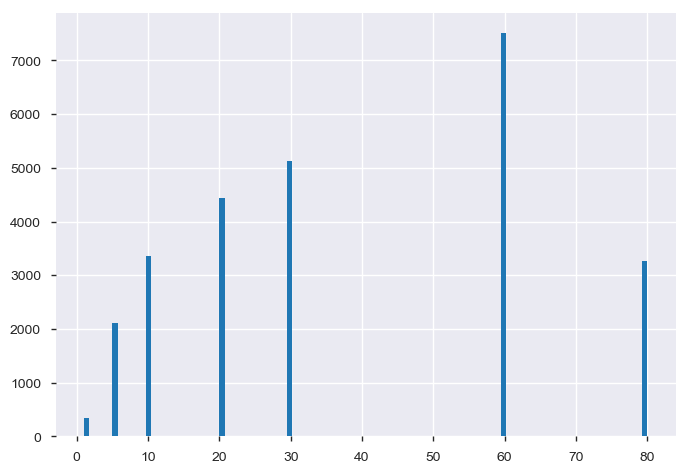

In [48]:
# useful_life_expectency_value has no outliers
data_prep_7['useful_life_expectency_value'].dropna().hist(bins=100)

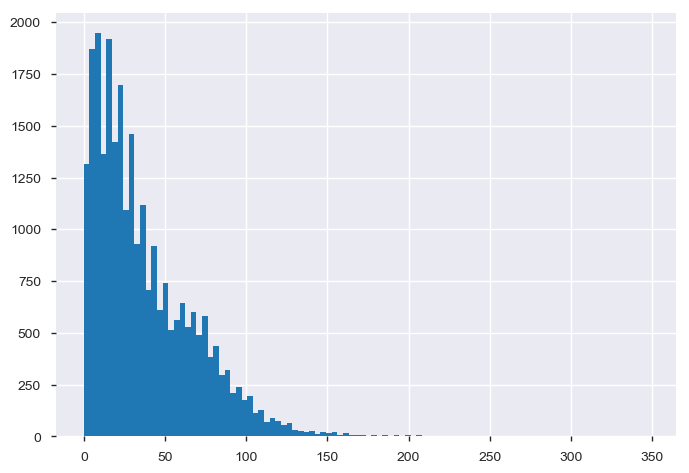

In [49]:
# diameter_breast_height has outliers
data_prep_7['diameter_breast_height'].dropna().hist(bins=100)

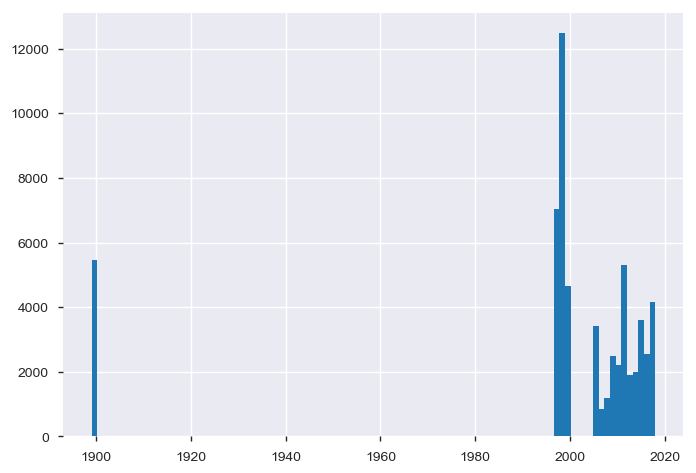

In [50]:
# year planted has outliers and nulls
data_prep_7['year_planted'].dropna().hist(bins=100)

**Notes on outliers:** <br>
- diameter_breast_height looks to be a right skewed distribution with no negative values - candidate for log transformation or robust scaling.
- Year planted has huge problems with continuity - wise to drop it!

In [55]:
del data_prep_7['year_planted']
cols_num.remove('year_planted')

In [56]:
data_prep_7.shape[0]

67558

In [57]:
# Apply transformations only to non null numeric rows
data_prep_7_num = data_prep_7.dropna(subset = cols_num)
data_prep_7_num.shape[0]

26171

In [58]:
# To manage outliers, we can remove them, mark them, or transform them

# removing them
# data_prep_8[] = data_prep_7[(data_prep_7[''] < lower_bound) |\
# (data_prep_7[''] > upper_bound)]

# marking them
# data_prep_8['_outlier'] = np.where(data_prep_7[''] > upper_bound)

# transforming them
data_prep_8_num = data_prep_7_num.copy()
data_prep_8_num["log_of_diameter_breast_height"] = \
    data_prep_8_num["diameter_breast_height"].apply(lambda x: np.log(x))

# or moving on/doing nothing
# data_prep_8 = data_prep_7.copy()

In [59]:
# diameter_breast_height after transformation
data_prep_8_num[['diameter_breast_height','log_of_diameter_breast_height']]

,diameter_breast_height,log_of_diameter_breast_height
com_id,,
1358448,19.0,2.944439
1033587,68.0,4.219508
1055443,20.0,2.995732
1286837,20.0,2.995732
1061404,14.0,2.639057
1023303,56.0,4.025352
1021029,70.0,4.248495
1022364,51.0,3.931826
1064912,7.0,1.945910


In [60]:
data_prep_8_num.describe().T

,count,mean,std,min,25%,50%,75%,max
diameter_breast_height,26171.0,37.554660,31.447876,0.000000,14.000000,29.000000,56.000000,347.000000
useful_life_expectency_value,26171.0,38.198005,25.176934,1.000000,20.000000,30.000000,60.000000,80.000000
latitude,26171.0,-37.807021,0.016692,-37.850058,-37.820205,-37.806251,-37.794053,-37.775633
longitude,26171.0,144.955849,0.020764,144.900445,144.942880,144.958291,144.972612,144.991056
log_of_diameter_breast_height,26171.0,-inf,NaN,-inf,2.639057,3.367296,4.025352,5.849325


In [61]:
# Feature transformation (i.e. rescaling) 

# The standard approach is minmax scaling. Note that this does not handle duplicate values.

# for c in cols_num:
#     data_prep_9[c].dropna() = minmax_scaling(data_prep_9[c].dropna(),columns = [0])

# Chris Albion recommends defaulting to standardization unless the model 
# demands otherwise

# Create scaler 
scaler = StandardScaler() 
# Transform the feature 

data_prep_8_num['useful_life_expectency_value_scaled']= scaler.fit_transform(data_prep_8_num['useful_life_expectency_value'].values.reshape(-1, 1)) 

# Show feature standardized
data_prep_8_num[['useful_life_expectency_value_scaled','useful_life_expectency_value']]

,useful_life_expectency_value_scaled,useful_life_expectency_value
com_id,,
1358448,1.660361,80.0
1033587,-0.722818,20.0
1055443,-0.325622,30.0
1286837,1.660361,80.0
1061404,-0.325622,30.0
1023303,-1.120015,10.0
1021029,-0.722818,20.0
1022364,-0.722818,20.0
1064912,1.660361,80.0


In [62]:
# Robust Scaler can handle values with outliers
rscaler = RobustScaler()
data_prep_8_num['diameter_breast_height_scaled']= rscaler.fit_transform(data_prep_8_num['diameter_breast_height'].values.reshape(-1, 1)) 

In [63]:
data_prep_8_num.describe().T

,count,mean,std,min,25%,50%,75%,max
diameter_breast_height,26171.0,3.755466e+01,31.447876,0.000000,14.000000,29.000000,56.000000,347.000000
useful_life_expectency_value,26171.0,3.819801e+01,25.176934,1.000000,20.000000,30.000000,60.000000,80.000000
latitude,26171.0,-3.780702e+01,0.016692,-37.850058,-37.820205,-37.806251,-37.794053,-37.775633
longitude,26171.0,1.449558e+02,0.020764,144.900445,144.942880,144.958291,144.972612,144.991056
log_of_diameter_breast_height,26171.0,-inf,NaN,-inf,2.639057,3.367296,4.025352,5.849325
useful_life_expectency_value_scaled,26171.0,8.314264e-17,1.000019,-1.477492,-0.722818,-0.325622,0.865968,1.660361
diameter_breast_height_scaled,26171.0,2.036824e-01,0.748759,-0.690476,-0.357143,0.000000,0.642857,7.571429


In [64]:
# Concatenating transformed numeric values back onto missing values
data_prep_9 = pd.concat([data_prep_8_num,data_prep_7[~data_prep_7.index.isin(data_prep_7_num.index)]])

In [111]:
# Another option is Min Max scaling, with example code below and more detail
# in the references for Section 6.
# NOTE that this does work with duplicates

# data_prep_9 = data_prep_8.copy()
# for c in cols_num:
#     data_prep_9[c].dropna() = minmax_scaling(data_prep_9[c].dropna(),columns = [0])

# If this is skipped
# data_prep_9 = data_prep_8.copy()

#### References for Section 6
[Min Max Scaling on Kaggle](https://www.kaggle.com/rtatman/data-cleaning-challenge-scale-and-normalize-data) <br>
Outliers function partially credited to Albon, Chris. Machine Learning with Python Cookbook: Practical Solutions from Preprocessing to Deep Learning (p. 70). O'Reilly Media. Kindle Edition. <br>

## 7. Cleaning: Boolean Features
<a id='Section7'></a>
[Go back to contents](#Section0) <br>
Involves encoding Booleans.

In [65]:
# Review bool cols values
[print(c, data_prep_9[c].value_counts(), sep="\n") for c in cols_bool] 

located_in
Park      39371
Street    28187
Name: located_in, dtype: int64


[None]

In [66]:
# create a replacement dict
replace_bool = {"located_in":{"Park":1,"Street":0}}

In [67]:
# Replace values for ints to encode bool
data_prep_10 = data_prep_9.copy()
data_prep_10 = data_prep_10.replace(to_replace=replace_bool)

In [68]:
# Review transformed bool cols values
[print(c, data_prep_10[c].value_counts(), sep="\n") for c in cols_bool] 

located_in
1    39371
0    28187
Name: located_in, dtype: int64


[None]

## 8. Cleaning: Date Features
<a id='Section8'></a>
[Go back to contents](#Section0) <br>
This section involves
- Date Encoding
- Date Feature Generation

In [69]:
# Review date cols
cols_date

['date_planted']

In [70]:
%%time
# Date encoding - note that this can be very slow, so it sometimes can be worthwhile specifying the datetime format
data_prep_11 = data_prep_10.copy()

for col in cols_date:
    data_prep_11[col] = pd.to_datetime(data_prep_11[col], infer_datetime_format = True)

Wall time: 10.5 s


In [72]:
# Date feature generation - for a tidy dataset, it can make sense to break out a date feature into day or month, 
data_prep_11['year_planted'] = data_prep_11['date_planted'].dt.year
data_prep_11['month_planted'] = data_prep_11['date_planted'].dt.month
data_prep_11['week_planted'] = data_prep_11['date_planted'].dt.week

## 9. Cleaning: Categorical Features
<a id='Section9'></a>
[Go back to contents](#Section0) <br>
- Standardization
- Cardinality Restriction
- Encoding

In [73]:
# Reviewing Categorical Features and Values
[print(col,data_prep_11[col].value_counts(),sep="\n") for col in cols_cat]

common_name
River Red Gum                 7860
London Plane                  5313
Spotted Gum                   3118
Yellow Box                    2935
Drooping She-Oak              2744
Elm                           2493
Black Wattle                  2341
English Elm                   1945
tba                           1910
Yellow Gum                    1481
Lemon Scented Gum             1356
Smooth-barked Apple Myrtle    1307
Lightwood Wattle              1244
Brush Box                      910
White Cedar                    814
Pin Oak                        733
Moreton Bay Fig                720
River Sheoak                   713
Ironbark                       661
Peppercorn Tree                641
Japanese Zelkova               620
Golden Wattle                  619
Kanooka                        586
Red Box                        563
Coastal Banksia                538
Sugar Gum                      536
Gum                            535
Cyprus Plane                   508
Hills Fi

[None, None]

In [74]:
# Standardizing all text in categorical columns to protect against data entry errors
punct_reg = re.compile('[%s+]' % re.escape(string.whitespace + string.punctuation))
def text_proc(text):
    proc = str(text)
    proc = proc.lower() #changes case to lower
    proc = proc.strip() #removes leading and trailing spaces/tabs/new lines
    proc = punct_reg.sub('_', proc)
    return proc

In [75]:
%%time
data_prep_12=data_prep_11.copy()
for col in cols_cat:
    data_prep_12[col] = data_prep_12[col].apply(lambda x: text_proc(x))

Wall time: 178 ms


In [76]:
# Evaluate code after transformation
[print(col,data_prep_12[col].value_counts(),sep="\n") for col in cols_cat]

common_name
river_red_gum                 7860
london_plane                  5313
spotted_gum                   3118
yellow_box                    2935
drooping_she_oak              2744
elm                           2493
black_wattle                  2341
english_elm                   1945
tba                           1910
yellow_gum                    1481
lemon_scented_gum             1356
smooth_barked_apple_myrtle    1307
lightwood_wattle              1244
brush_box                      910
white_cedar                    814
pin_oak                        733
moreton_bay_fig                720
river_sheoak                   713
ironbark                       661
peppercorn_tree                641
japanese_zelkova               620
golden_wattle                  619
kanooka                        586
red_box                        563
coastal_banksia                538
sugar_gum                      536
gum                            535
cyprus_plane                   508
swamp_sh

[None, None]

In [77]:
# The following code takes a list of features and restricts their range of possible values - or cardinality.
# It fills the NA's as other_infrequent_value
feats_distros = dict()
for c in cols_cat:
    df = data_prep_12[c]
    df = df.value_counts()
    df.fillna(0, inplace=True)
    df = df.astype(np.int32)
    df.sort_values(ascending = False, inplace = True)
    df = pd.DataFrame(df)
    df.columns = [c + ' count']
    df[c + ' distribution'] = 100*df/df.sum()
    feats_distros.update({c:df})

for feat in cols_cat:
    feat_distro = feats_distros[feat][feat + ' distribution']
    feat_index = feat_distro[feat_distro < 1].index.tolist()
    lean_feat_index = len(feat_index)
    if lean_feat_index > 0:
        feat_sub = lean_feat_index*[np.nan]
        feat_dict = dict(zip(feat_index, feat_sub))
        data_prep_12[feat] = data_prep_12[feat].replace(feat_dict)
    data_prep_12[feat].fillna('other_infrequent_value',inplace=True)

In [78]:
# Evaluate values after transformation
[print(col,data_prep_12[col].value_counts(),sep="\n") for col in cols_cat]
# This did a good job - from 360 values to under 20 values!

common_name
other_infrequent_value        27621
river_red_gum                  7860
london_plane                   5313
spotted_gum                    3118
yellow_box                     2935
drooping_she_oak               2744
elm                            2493
black_wattle                   2341
english_elm                    1945
tba                            1910
yellow_gum                     1481
lemon_scented_gum              1356
smooth_barked_apple_myrtle     1307
lightwood_wattle               1244
brush_box                       910
white_cedar                     814
pin_oak                         733
moreton_bay_fig                 720
river_sheoak                    713
Name: common_name, dtype: int64
age_description
nan                       41387
semi_mature               10968
mature                     9243
juvenile                   4132
new                        1505
other_infrequent_value      323
Name: age_description, dtype: int64


[None, None]

In [79]:
# Encoding categorical features
# Ordinal categories can be handled through replace
scale_mapper = {'new':1,
                'juvenile':2,
                'semi_mature':3,
                'mature':4,
                'over_mature':5,
                'other_infrequent_value':5,
                'nan':np.nan
               }
data_prep_12['age_description'] = data_prep_12['age_description'].replace(to_replace=scale_mapper)

In [80]:
# Nominal categories can be handled through one hot encoding or dummification
data_prep_13 = pd.get_dummies(data_prep_12, prefix = None, prefix_sep = '-', dummy_na = False, columns = ['common_name'])

In [81]:
data_prep_13.columns.tolist()

['age_description',
 'date_planted',
 'diameter_breast_height',
 'diameter_breast_height_scaled',
 'latitude',
 'located_in',
 'log_of_diameter_breast_height',
 'longitude',
 'useful_life_expectency_value',
 'useful_life_expectency_value_scaled',
 'year_planted',
 'month_planted',
 'week_planted',
 'common_name-black_wattle',
 'common_name-brush_box',
 'common_name-drooping_she_oak',
 'common_name-elm',
 'common_name-english_elm',
 'common_name-lemon_scented_gum',
 'common_name-lightwood_wattle',
 'common_name-london_plane',
 'common_name-moreton_bay_fig',
 'common_name-other_infrequent_value',
 'common_name-pin_oak',
 'common_name-river_red_gum',
 'common_name-river_sheoak',
 'common_name-smooth_barked_apple_myrtle',
 'common_name-spotted_gum',
 'common_name-tba',
 'common_name-white_cedar',
 'common_name-yellow_box',
 'common_name-yellow_gum']

## 10. Cleaning: Other Features
<a id='Section10'></a>
[Go back to contents](#Section0) <br>
Section for ad hoc or specialised cleaning.

In [ ]:
# I.e. for Geo features - obtaining postcode for each tree
# Though there is a limit of 1 search per second!
# import sys
# !{sys.executable} -m pip install geopy

In [82]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()

In [83]:
result = geolocator.reverse("-37.794463412577585, 144.93192049089112")

In [84]:
result.raw['address']['postcode']

'3000'

In [85]:
result.raw['address'].keys()

dict_keys(['car_repair', 'road', 'suburb', 'city', 'county', 'region', 'state', 'postcode', 'country', 'country_code'])

## 11. Evaluation of Prepared Data
<a id='Section11'></a>
[Go back to contents](#Section0) <br>
This section involves
- profiling the cleaned data
- Managing any remaining warnings
- Saving the dataset in the HDF5 format
- noting things to change based on the feedback from modelling (i.e. the MSE of estimators)

In [86]:
# Profile cleaned data
report2 = pandas_profiling.ProfileReport(data_prep_13)
report2

Number of variables,33
Number of observations,67558
Total Missing (%),6.7%
Total size in memory,8.4 MiB
Average record size in memory,131.0 B
Numeric,8
Categorical,0
Boolean,20
Date,1
Text (Unique),0
Rejected,4


In [87]:
# drop some columns
data_prep_14 = data_prep_13.drop(labels=['date_planted','diameter_breast_height','log_of_diameter_breast_height',\
                                         'useful_life_expectency_value','month_planted','week_planted','year_planted',\
                                         'latitude','longitude'],axis=1)

In [88]:
# Impute missing values in ['diameter_breast_height_scaled','useful_life_expectency_value_scaled']
# Fit and apply imputation
mean_imputer = Imputer(missing_values=np.nan, strategy='mean', axis=0)
mean_imputer_fit = mean_imputer.fit(data_prep_14[['diameter_breast_height_scaled','useful_life_expectency_value_scaled','age_description']])
data_prep_14_imputed = pd.DataFrame(data = mean_imputer_fit.transform(data_prep_14[['diameter_breast_height_scaled','useful_life_expectency_value_scaled','age_description']].values)\
            ,index=data_prep_14.index \
            ,columns=data_prep_14[['diameter_breast_height_scaled','useful_life_expectency_value_scaled','age_description']].columns)
data_prep_14_imputed

,diameter_breast_height_scaled,useful_life_expectency_value_scaled,age_description
com_id,,,
1358448,-0.238095,1.660361e+00,3.000000
1033587,0.928571,-7.228185e-01,4.000000
1055443,-0.214286,-3.256219e-01,3.000000
1286837,-0.214286,1.660361e+00,2.000000
1061404,-0.357143,-3.256219e-01,3.000000
1023303,0.642857,-1.120015e+00,4.000000
1021029,0.976190,-7.228185e-01,4.000000
1022364,0.523810,-7.228185e-01,4.000000
1064912,-0.523810,1.660361e+00,2.000000


In [89]:
data_prep_15 = \
pd.concat([data_prep_14_imputed,data_prep_14.drop(['diameter_breast_height_scaled','useful_life_expectency_value_scaled','age_description'],axis=1)],axis=1)

In [90]:
data_prep_15.head()

,diameter_breast_height_scaled,useful_life_expectency_value_scaled,age_description,located_in,common_name-black_wattle,common_name-brush_box,common_name-drooping_she_oak,common_name-elm,common_name-english_elm,common_name-lemon_scented_gum,common_name-lightwood_wattle,common_name-london_plane,common_name-moreton_bay_fig,common_name-other_infrequent_value,common_name-pin_oak,common_name-river_red_gum,common_name-river_sheoak,common_name-smooth_barked_apple_myrtle,common_name-spotted_gum,common_name-tba,common_name-white_cedar,common_name-yellow_box,common_name-yellow_gum
com_id,,,,,,,,,,,,,,,,,,,,,,,
1358448,-0.238095,1.660361,3.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1033587,0.928571,-0.722818,4.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1055443,-0.214286,-0.325622,3.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1286837,-0.214286,1.660361,2.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1061404,-0.357143,-0.325622,3.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [91]:
%%time
report3 = pandas_profiling.ProfileReport(data_prep_15)

Wall time: 9.53 s


In [92]:
report3

Number of variables,24
Number of observations,67558
Total Missing (%),0.0%
Total size in memory,3.8 MiB
Average record size in memory,59.0 B
Numeric,4
Categorical,0
Boolean,20
Date,0
Text (Unique),0
Rejected,0


In [93]:
report3.to_file('data/prepped_data_profile.html')

In [94]:
%%time
# Saving data to HDF5 format
data_prep_15.to_hdf('data/trees_prepped.h5', key = 'data_prep_15', mode = 'w', append = True, format = 'table',\
          index = False, complib = 'blosc', optlevel = 9, data_columns = list(data_prep_15.index.names))

Wall time: 716 ms


In [95]:
# Evaluation - can the data be used with a random forest estimator
from sklearn.model_selection import train_test_split
X = data_prep_15.drop('located_in',axis=1)
y = data_prep_15.located_in
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [96]:
from sklearn.ensemble import RandomForestClassifier
rfclf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfclf.fit(X_train,y_train)
rfclf.score(X_test, y_test)

0.7603611604499704

Yes it can! But does it beat the dummy?

In [97]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='most_frequent',random_state=0)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.5819271758436945

In [98]:
# What features are important in the random forest?
pd.DataFrame({'feature':X.columns, 'importance':rfclf.feature_importances_}).sort_values(by='importance',ascending=False) 

,feature,importance
0,diameter_breast_height_scaled,0.304287
1,useful_life_expectency_value_scaled,0.122096
10,common_name-london_plane,0.112766
2,age_description,0.102456
14,common_name-river_red_gum,0.062569
6,common_name-elm,0.033224
3,common_name-black_wattle,0.031477
12,common_name-other_infrequent_value,0.029509
16,common_name-smooth_barked_apple_myrtle,0.027536
18,common_name-tba,0.019627


The most predictive feature was "diameter_breast_height_scaled" (bigger trees are in a Park - makes sense!)

## 12. Construction of a Prep Pipeline
<a id='Section12'></a>
[Go back to contents](#Section0) <br>
Once data transformations are finalized, it makes sense to group them into a pipeline, to allow for reproducible file handling <br>
Functions are a great way to group this. <br>
Below is an example block from another project. The next version of this workbook will build this out. <br>
This workbook didn't touch much on dummification of categorical variables - so some code will be available for that as well. <br>

In [ ]:
# Not done yet

## 13. References
<a id='Section13'></a>
[Go back to contents](#Section0) <br>
- [Chris Albion’s blog](https://chrisalbon.com/) and [recently published book](https://www.amazon.com/Machine-Learning-Python-Cookbook-Preprocessing/dp/1491989386/ref=sr_1_1)
- [Theadore Petrou’s Pandas Cookbook](https://www.packtpub.com/big-data-and-business-intelligence/pandas-cookbook)
- Racheal Tatman’s [Data Cleaning Challenge](https://www.kaggle.com/rtatman/data-cleaning-challenge-handling-missing-values) and [blog](http://www.rctatman.com/)
- Katharine Jarmul’s [Automating Data Cleanup with Python](https://www.youtube.com/watch?v=gp-ngPV_ZX8)
- Data Camp’s [Importing and Cleaning data with Python](https://www.datacamp.com/tracks/importing-cleaning-data-with-python)
- [Luis Daniel Lopez-Sanchez](https://www.linkedin.com/in/luis-daniel-l%C3%B3pez-s%C3%A1nchez-5b624864/)